In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from scipy import optimize, stats

import nilearn
from nilearn import plotting
from nilearn import masking
from nilearn.input_data import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# import pingouin as pg

import random
# from random import random as rand

import re

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline

In [3]:
def fast_masking(img, roi):
    ## img : data (NIFTI image)
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    if img_data.shape != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
    ## the shape is (n_trials, n_voxels) which is to cross-validate for runs. =(n_samples, n_features)
    return img_data[roi_mask]

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [5]:
dir_root = join('/mnt/ext4/GL/fmri_data')
dir_stat = join(dir_root, 'stats')
dir_mask = join(dir_root, 'masks')

In [6]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

---
---

In [7]:
thresh = stats.norm.isf(0.5e-3) # p=1.e-3
# thresh = stats.norm.isf(0.5e-4) # p=1.e-4
# thresh = stats.norm.isf(0.5e-5) # p=1.e-5

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



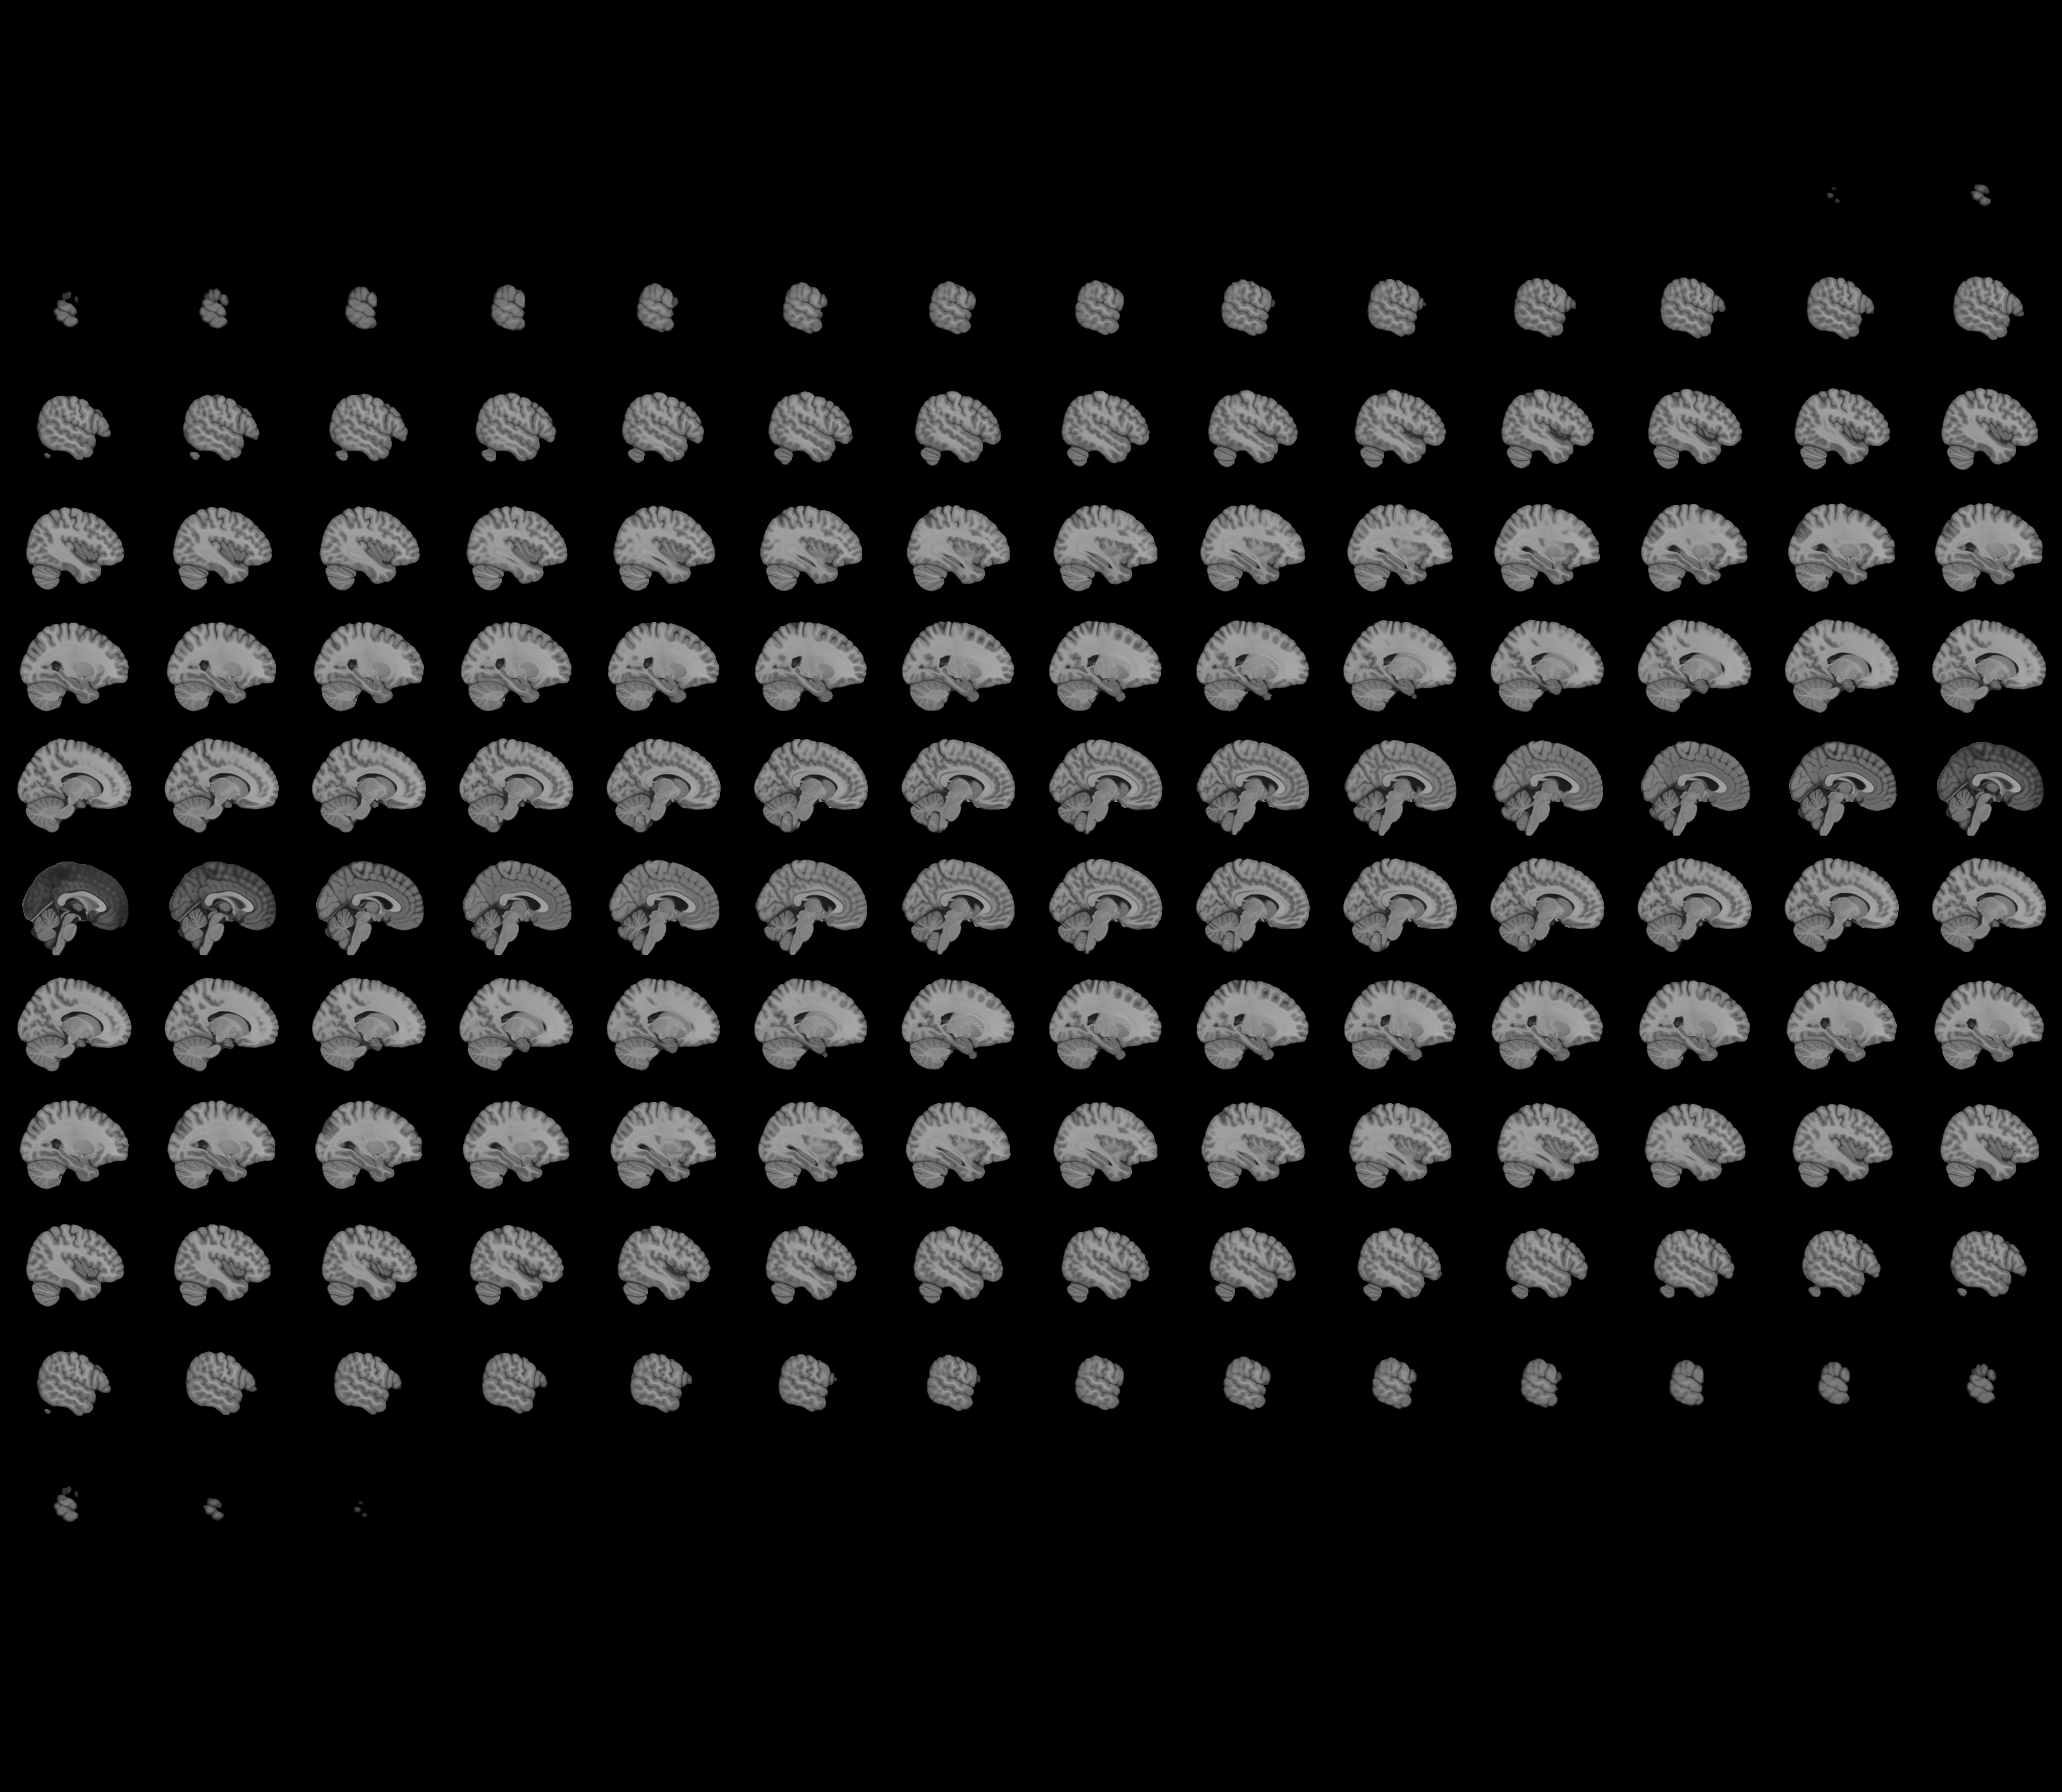
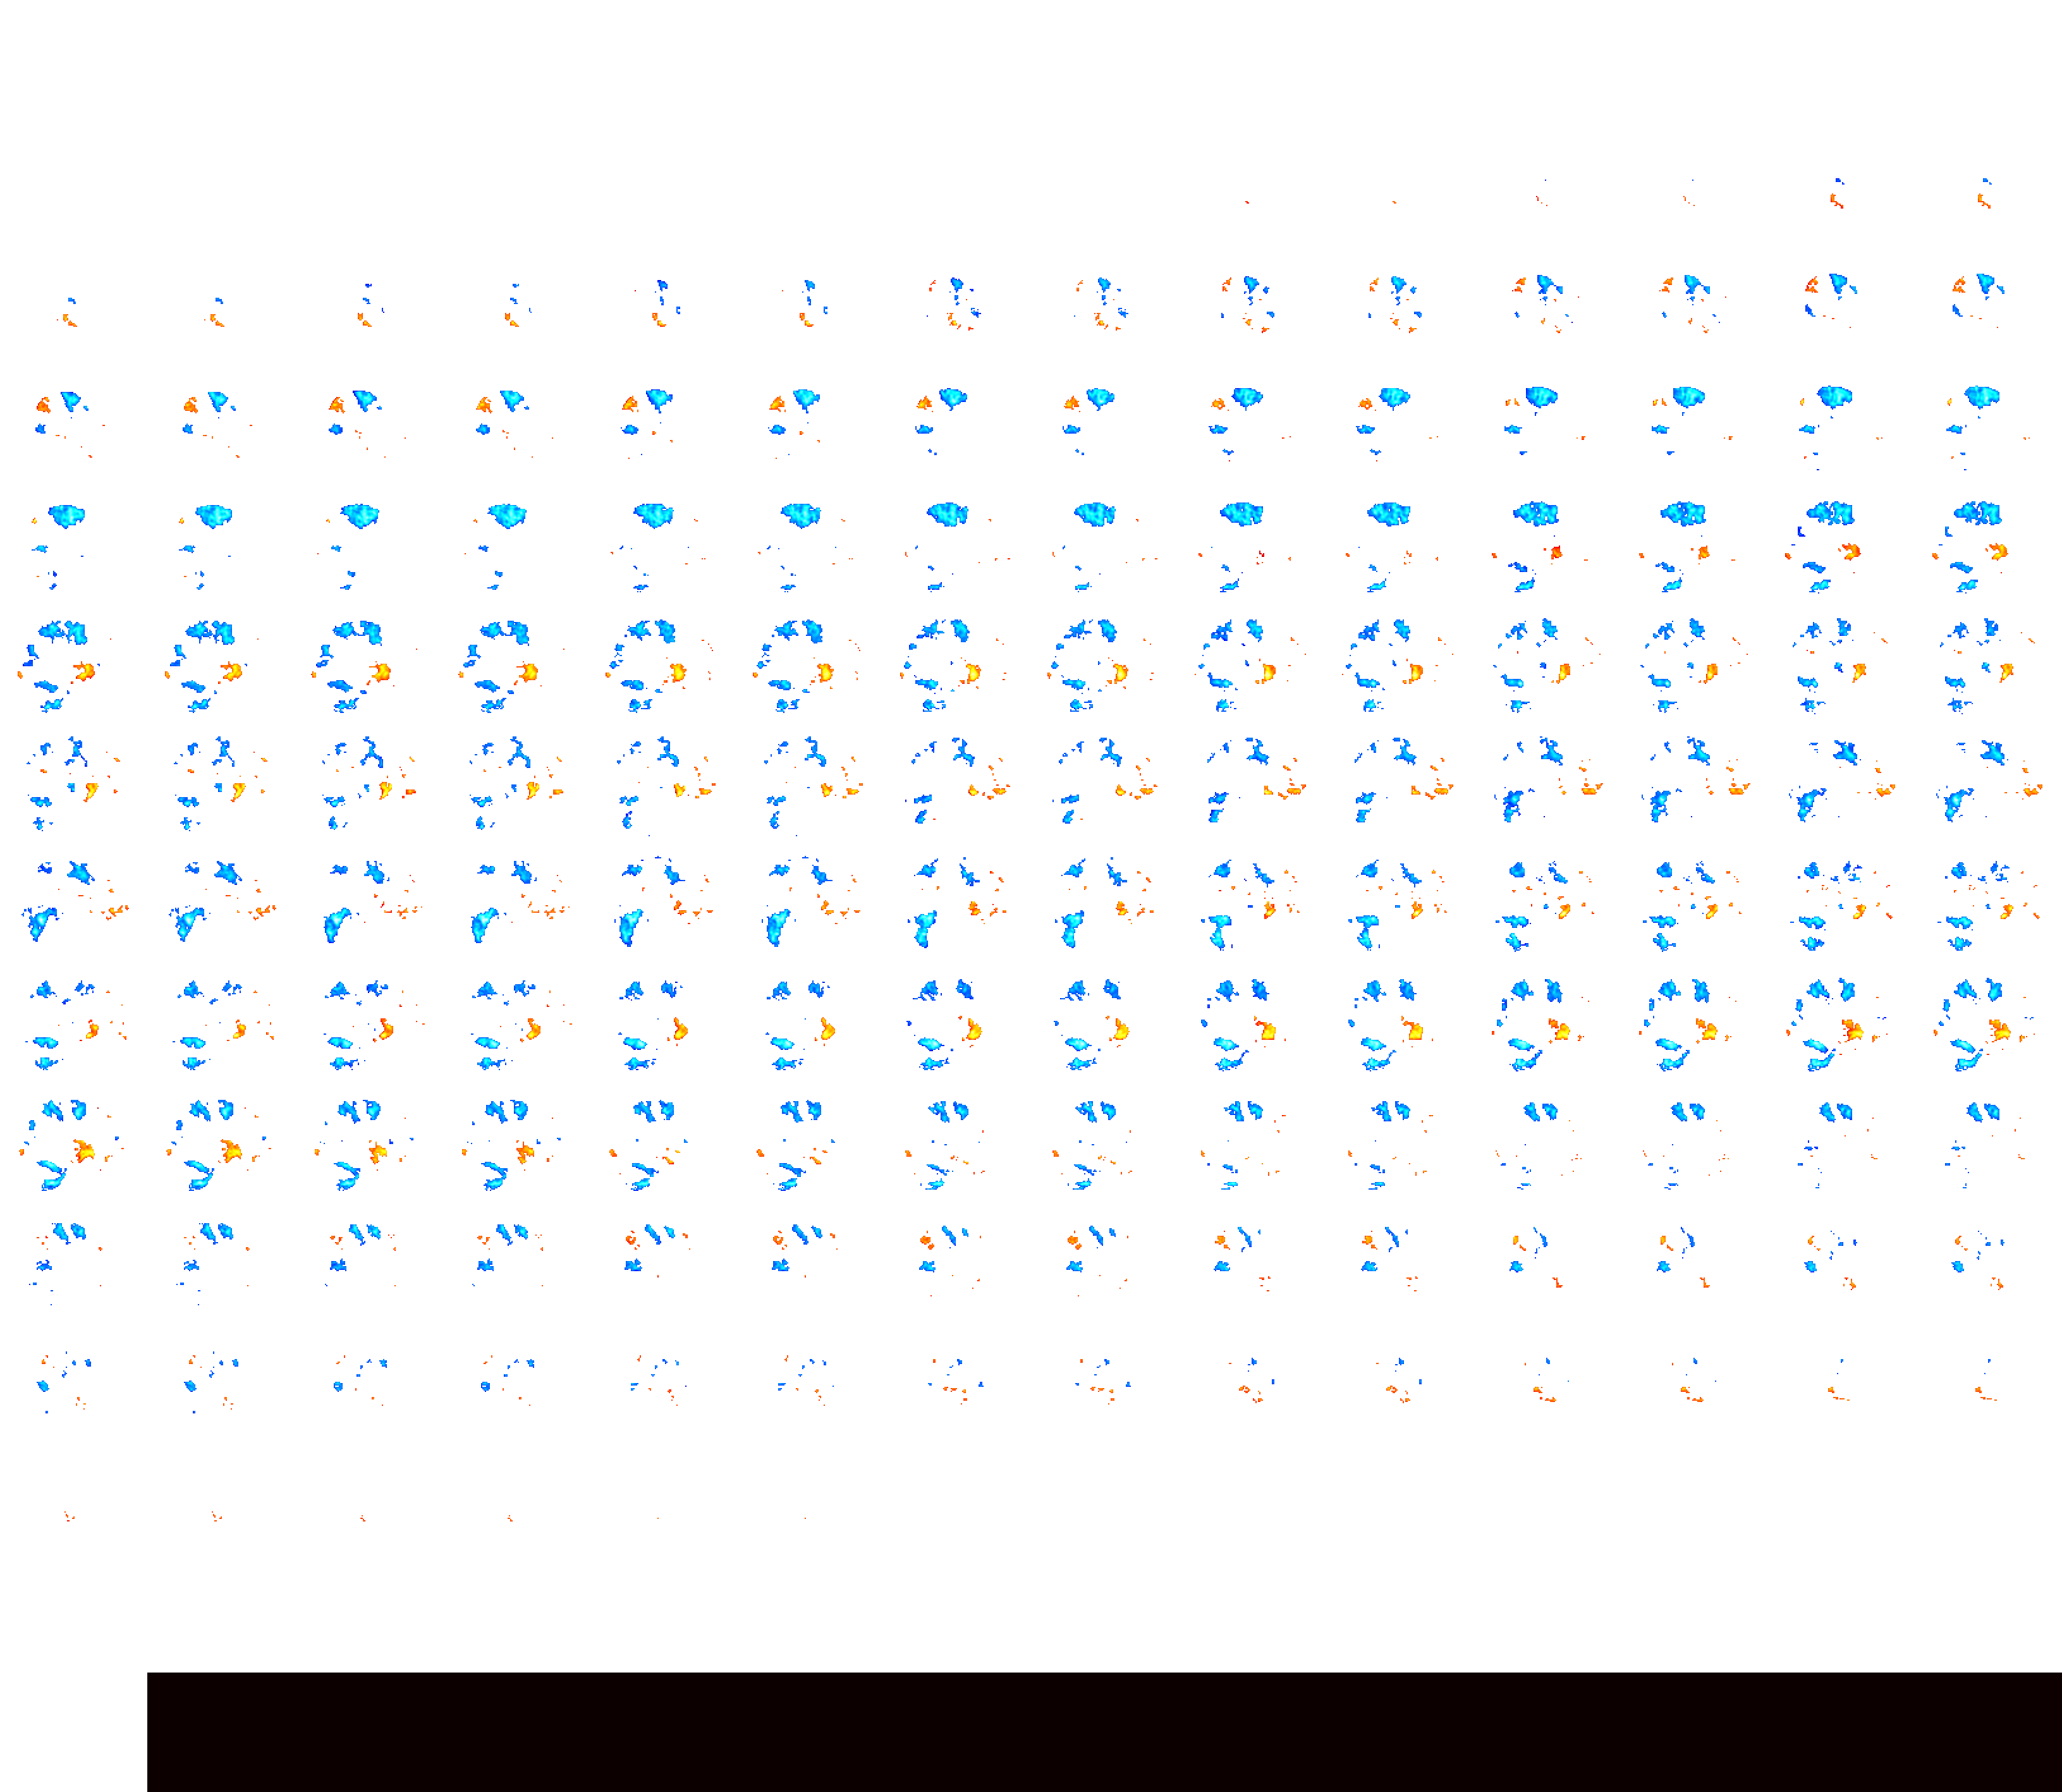

In [8]:
shift = '4s_shifted'
fname_stat = join(dir_stat, "GLM.block_design.%s.KJH/group.SetA_Zscr.nii"%shift)

nilearn.plotting.view_img(
    fname_stat
    , threshold=thresh
    , vmax=6.8
)

/usr/local/fsl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



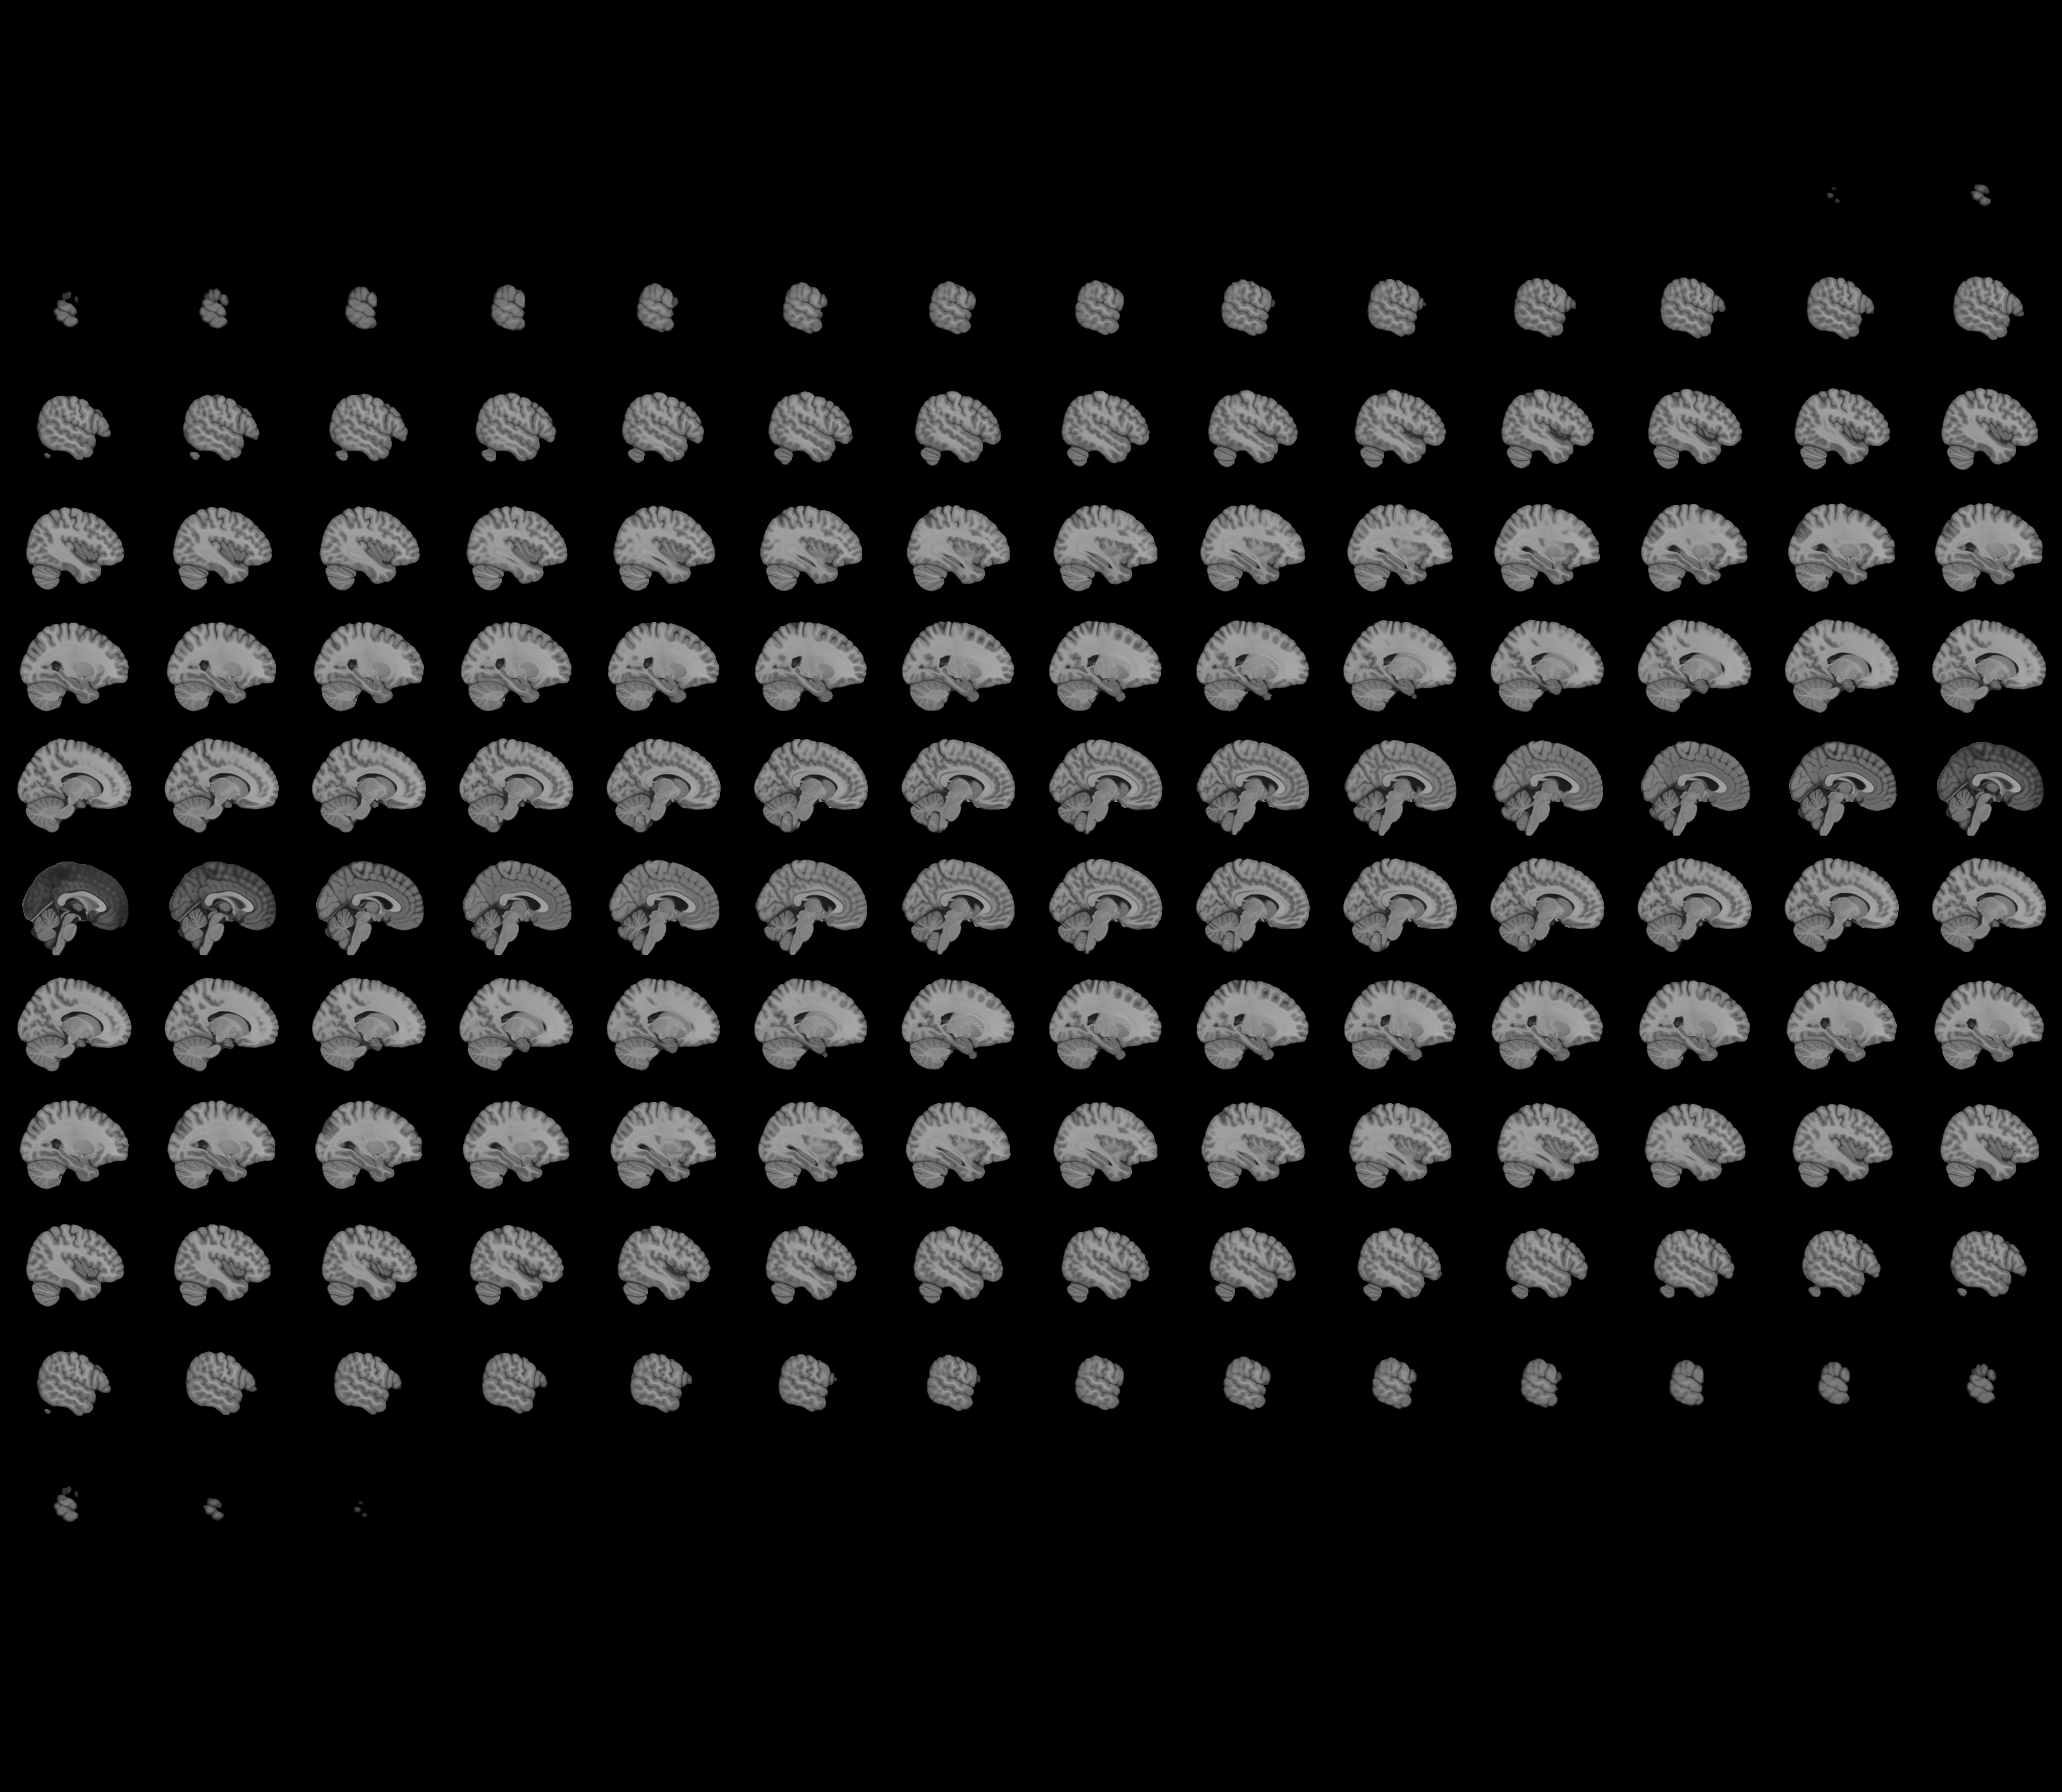
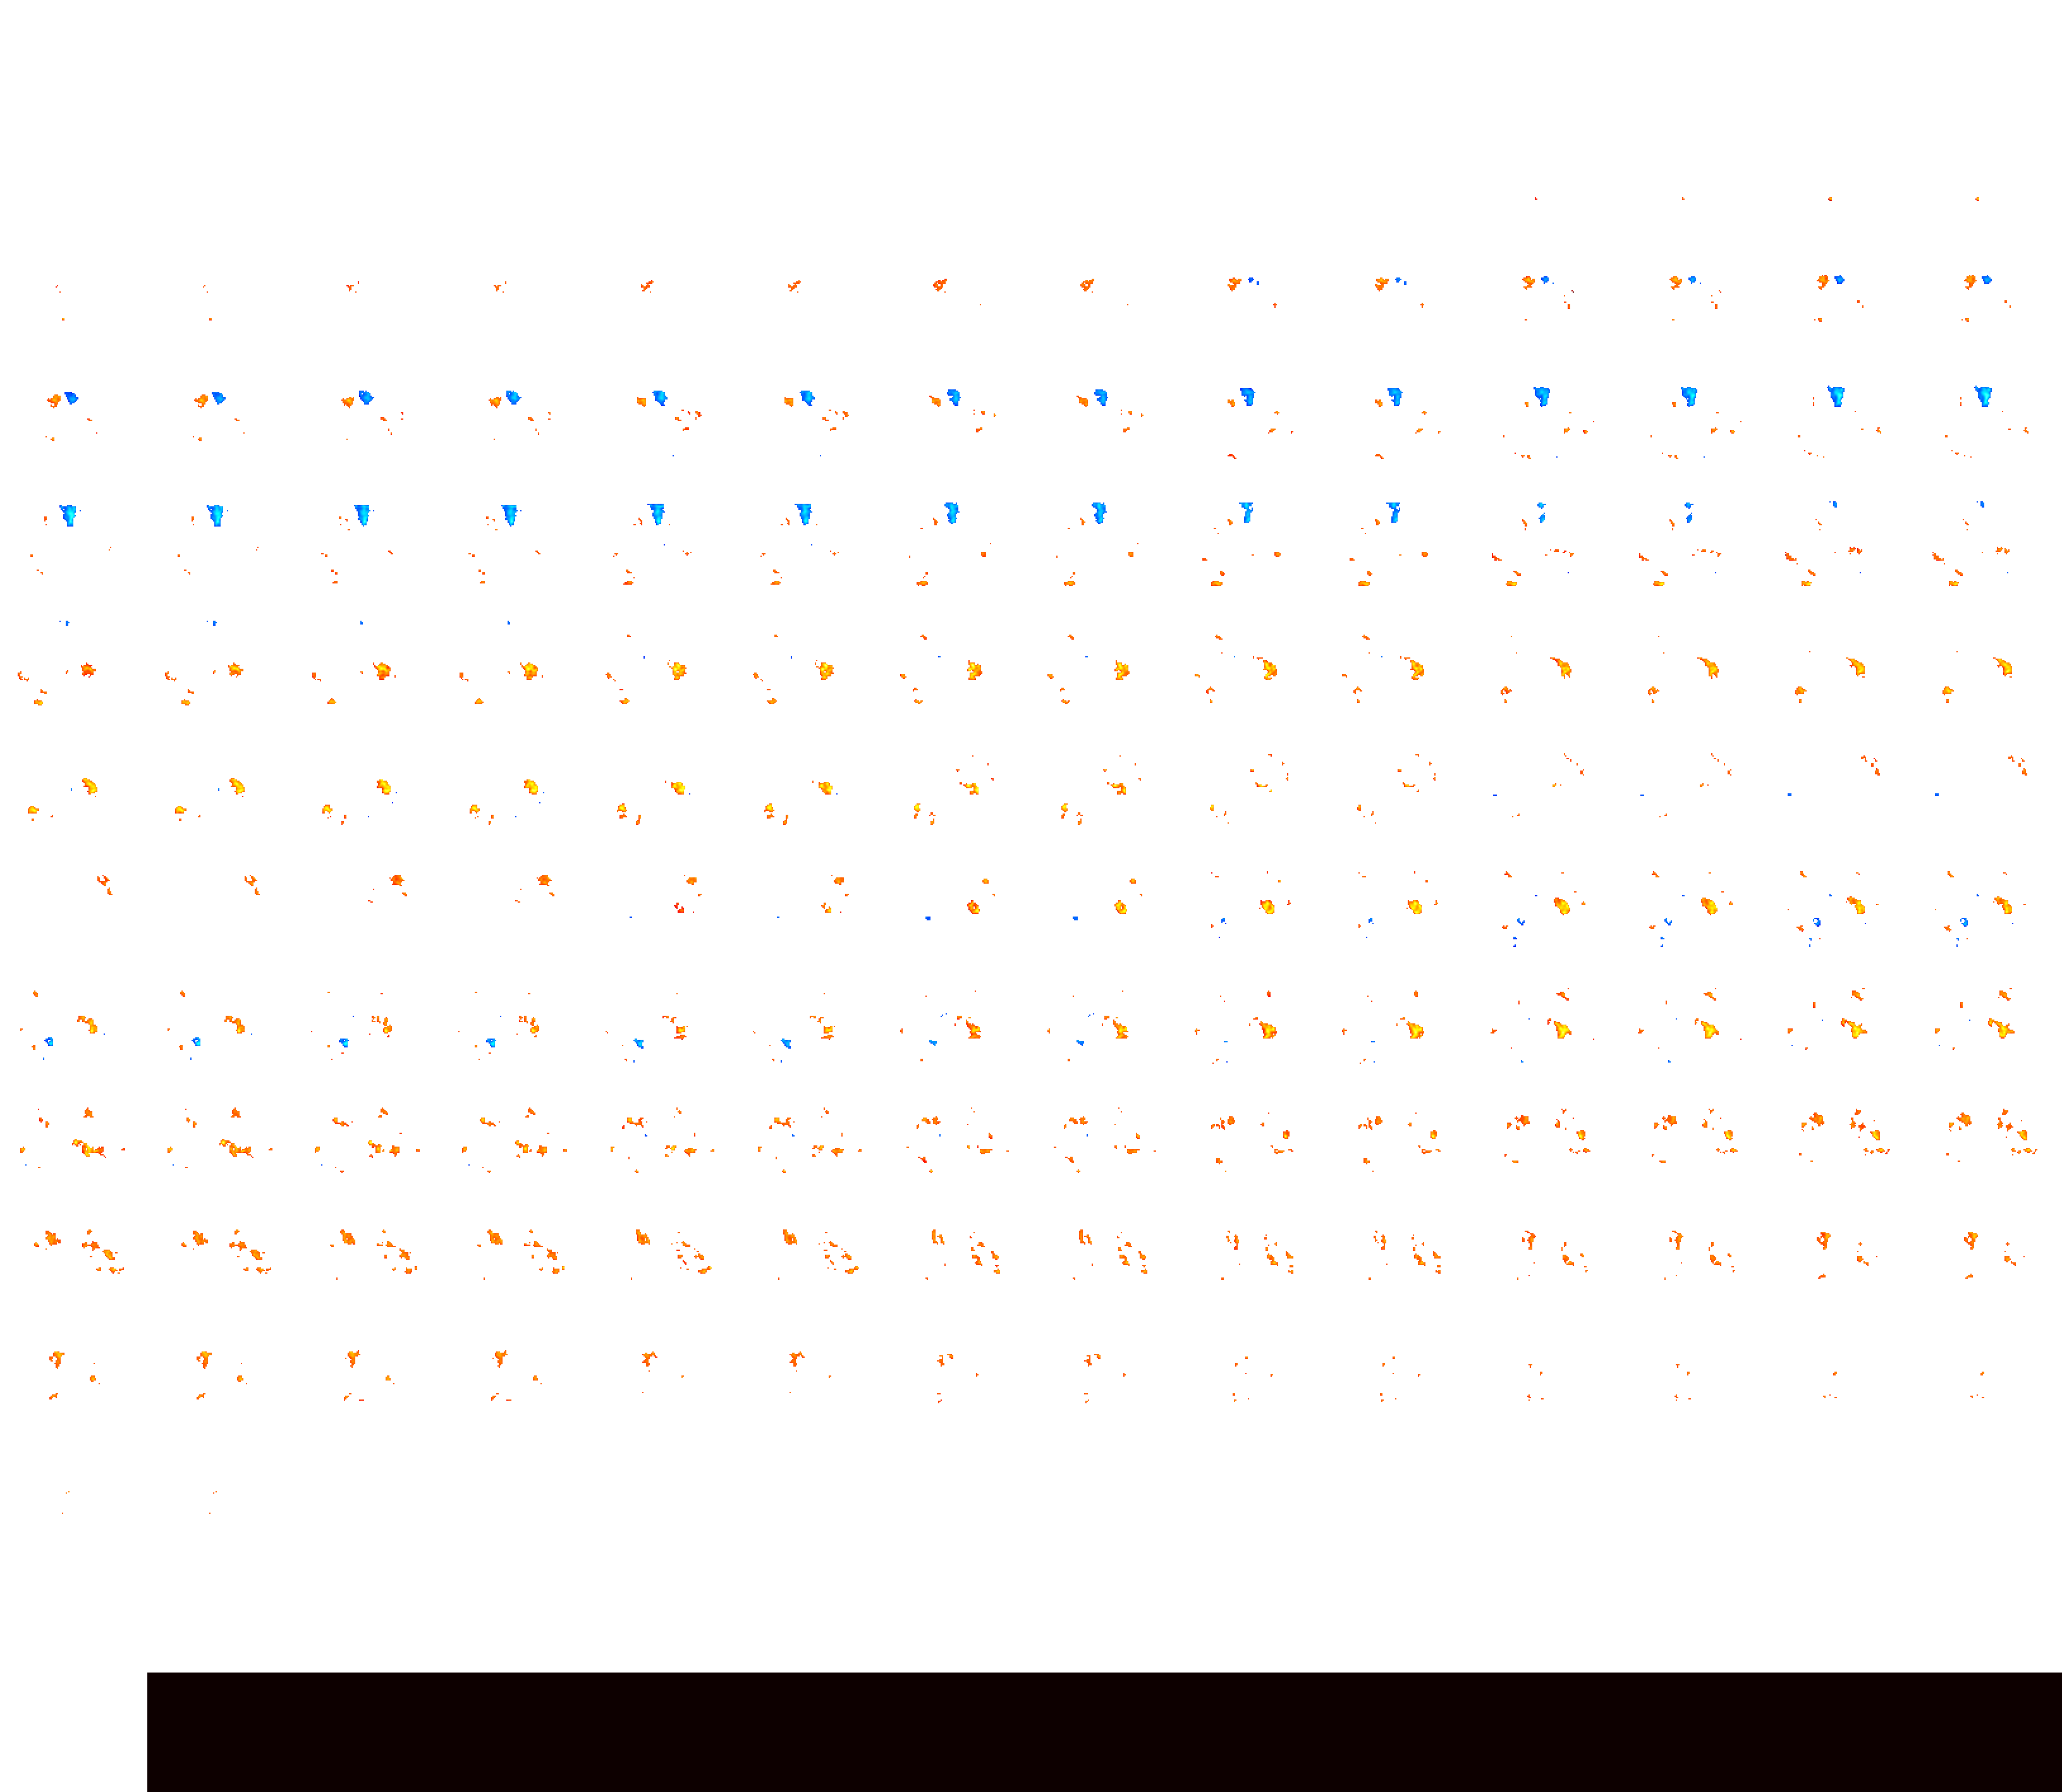

In [9]:
shift = '4s_shifted'
fname_stat = join(dir_stat, "GLM.block_design.%s.KJH/group.SetB_Zscr.nii"%shift)

nilearn.plotting.view_img(
    fname_stat
    , threshold=thresh
    , vmax=6.8
)

In [23]:
view_cut = {}
view_cut['sagittal'] = [-55, -22, -7, -3 , 7, 22, 55]
view_cut['axial'] = [-7, -2, 2, 7, 10, 44, 55]

---

/tmp/ipykernel_136364/4057384741.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


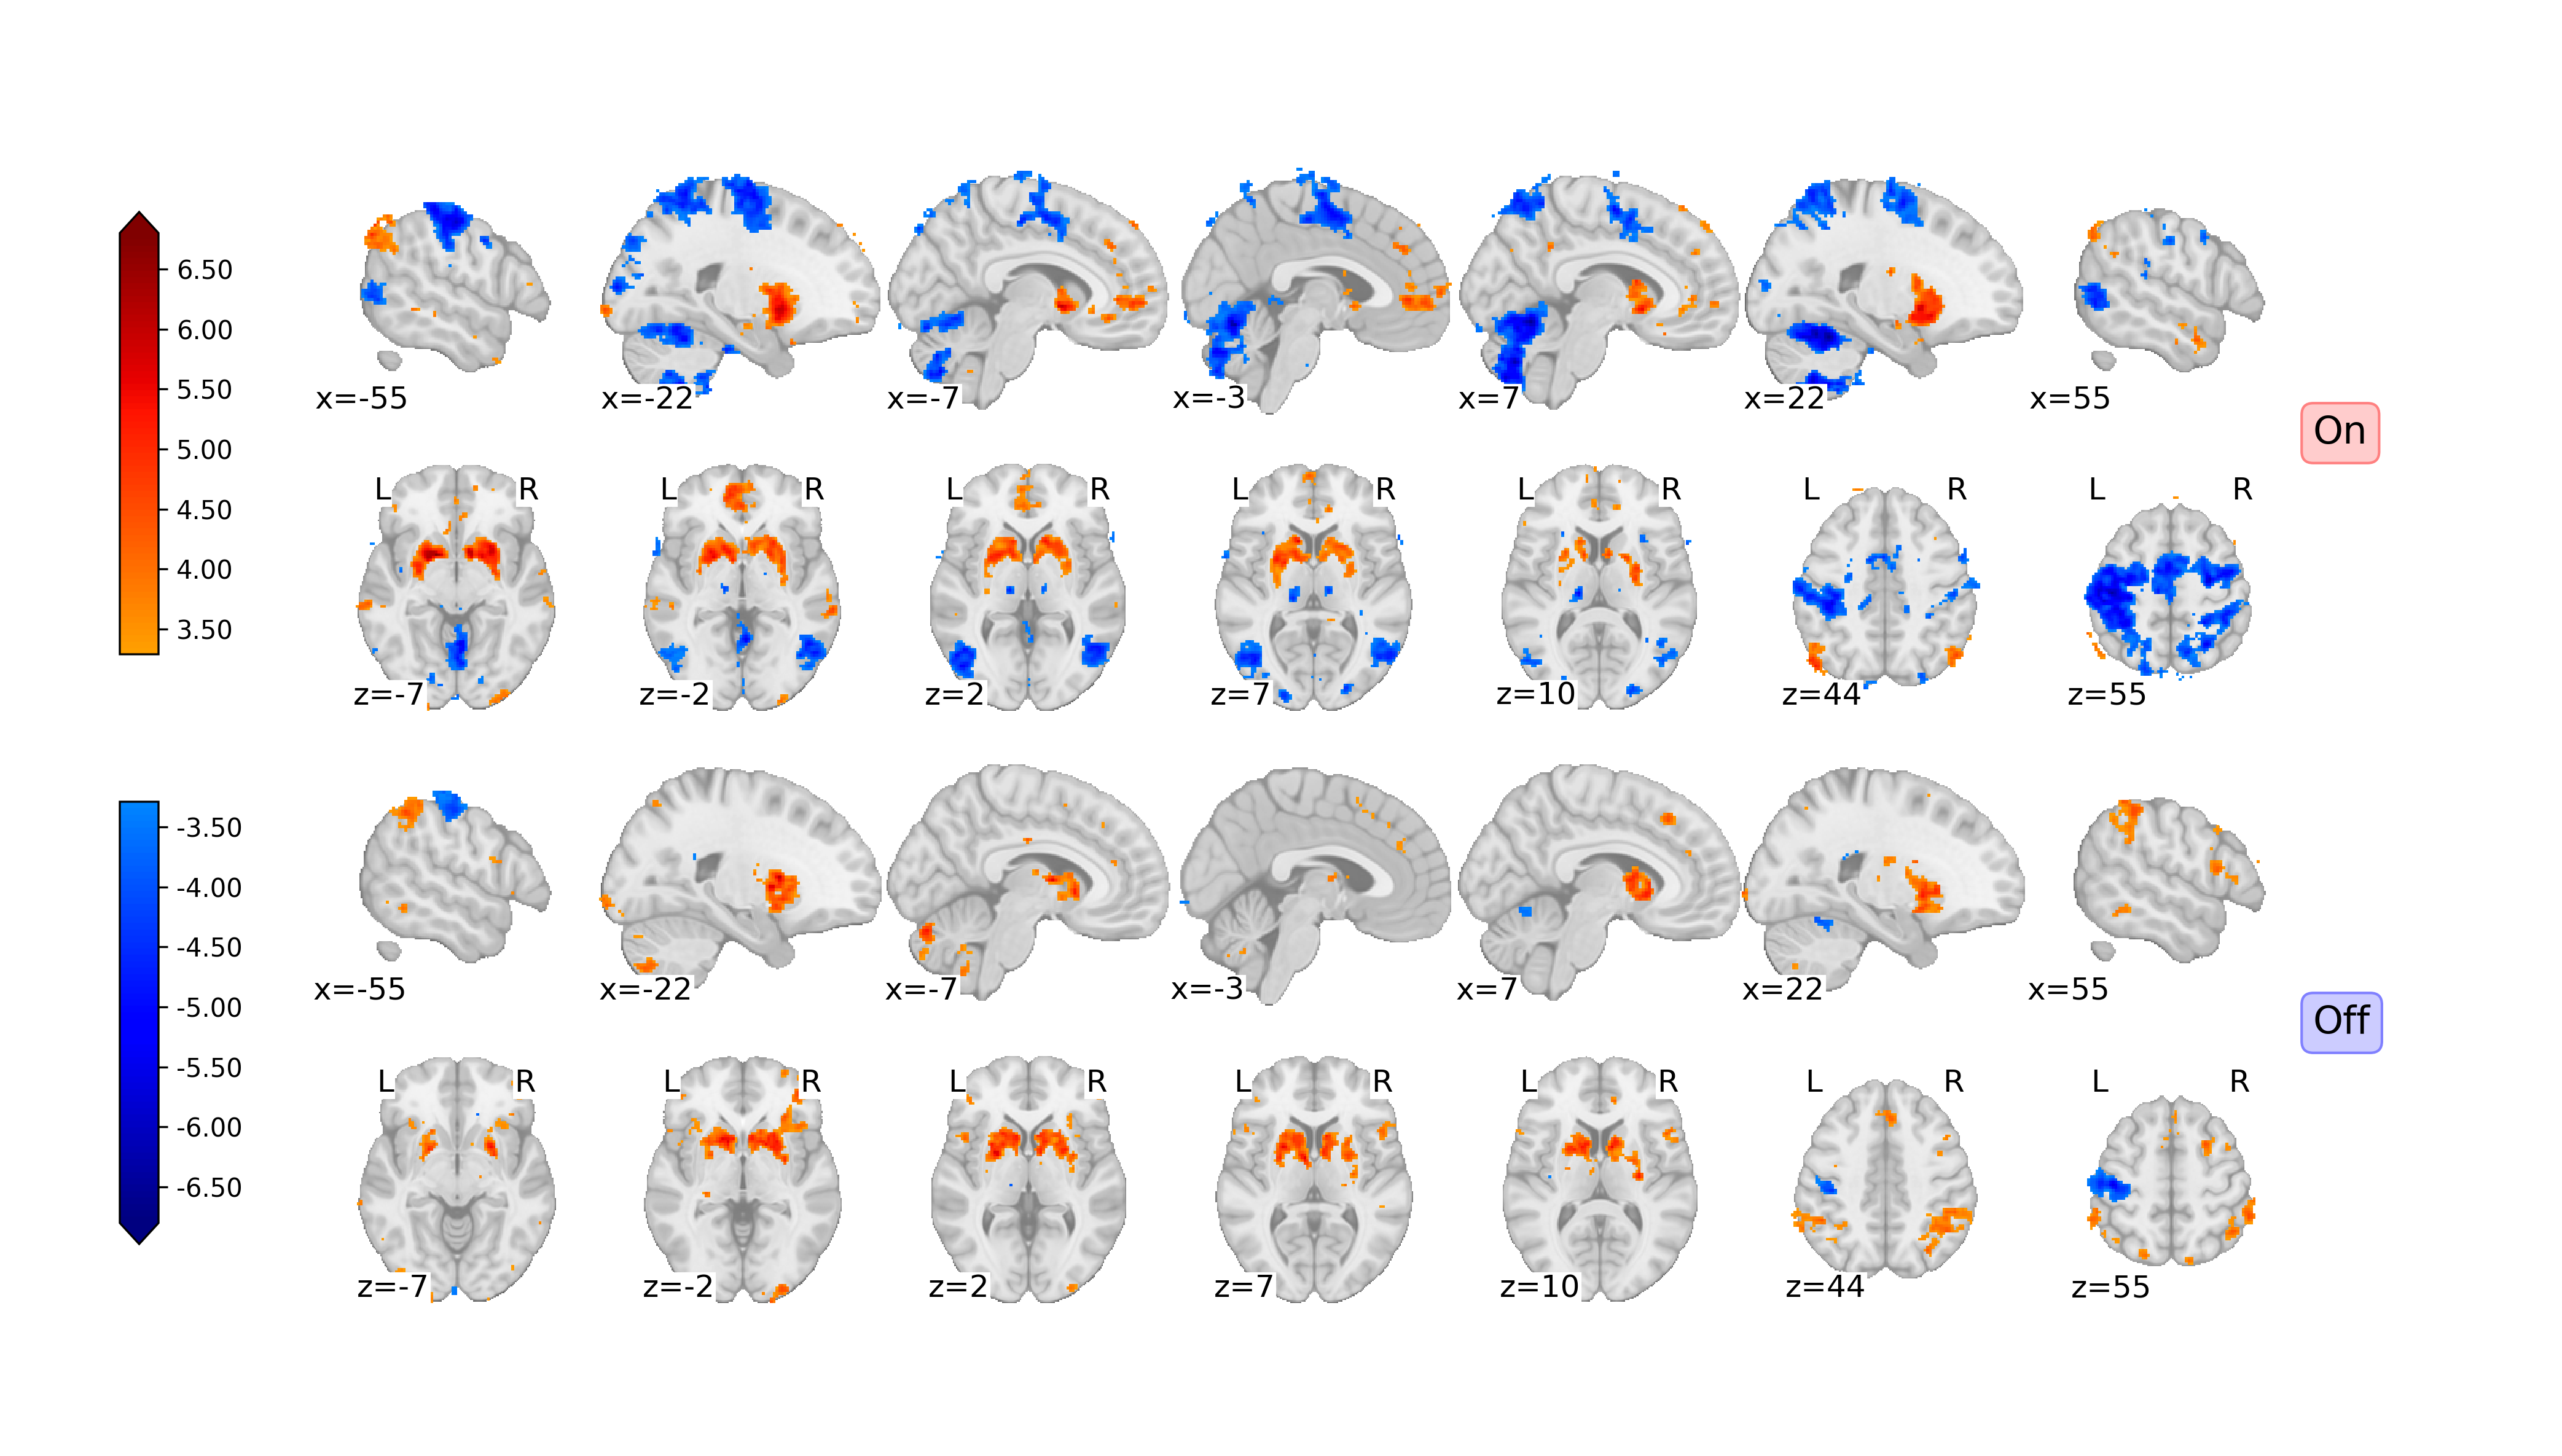

In [29]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(2*7,4*2), dpi=300)

shift = '4s_shifted'
for ii, cond in enumerate(['SetA', 'SetB']):
    for jj, (axis, coord) in enumerate(view_cut.items()):
        ax = axs[ii*2+jj]
        fname_stat = join(dir_stat, "GLM.block_design.%s.KJH/group.%s_Zscr.nii"%(shift,cond))
        
#         ## positive
#         img_stat = nilearn.image.math_img(img1=fname_stat, formula='(img1>0) * img1')

        ## positive & negative
        img_stat = fname_stat
        
        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='x' if axis=='sagittal' else 'z'
            , cut_coords=coord
            , symmetric_cbar=False, vmax=6.8
            , cmap='jet', colorbar=False
            , axes=ax
        )

## 최대 최소 설정
vmax = 6.8
vmin = -6.8
norm = colors.Normalize(vmin=vmin, vmax=vmax)

################
## upper cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=vmax)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.05, 0.55, .015, 0.3])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)

################
## lower cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=vmin, vmax=-thresh)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.05, 0.15, .015, 0.3])
cbar = fig.colorbar(
    colormapping, extend='min'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)

## titles
fig.text(
    0.9, 0.7, 'On'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(1., 0.5, 0.5)
        , fc=(1., 0.8, 0.8)
    )
)
fig.text(
    0.9, 0.3, 'Off'
    , size=15, rotation=0
    , ha='left', va='center'
    , bbox=dict(
        boxstyle='round'
        , ec=(0.5, 0.5, 1)
        , fc=(0.8, 0.8, 1)
    )
)

fig.tight_layout()

In [30]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/statmap.4s_shifted.Zscr.FB_vs_nFB.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

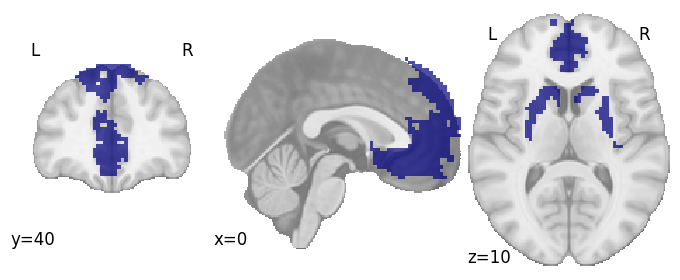

In [19]:
nilearn.plotting.plot_roi(
    join(dir_mask, 'mask.NN=1.clust0001.p=1.e-3.nii')
    , display_mode='ortho', draw_cross=False
    , cut_coords=[0, 40, 10]
)

In [20]:
df = pd.DataFrame(columns=['region', 'stim', 'nvoxels', 'pval', 'type', 'Z_thresh'])

for pval in [1e-3, 1e-4, 1e-5]:
    thresh = stats.norm.isf(pval*0.5)
    for group in ['dlPFC_cTBS', 'M1_cTBS']:
        region = 'DLPFC' if 'dlPFC' in group else 'M1'
        stim = 'cTBS' if 'cTBS' in group else '20Hz'
        zscr[group] = fast_masking(
            img=nilearn.image.load_img(glob(join(dir_stat, 'AM/%s/%.1fs_shifted/GP.%s.Zscr.n??.nii'%(glm, shift, group)))[0])
            , roi=nilearn.image.load_img(join(dir_mask, 'mask.NN=1.clust0001.p=1.e-3.nii'))
        )
        tmp = zscr[group]
        nvoxels = tmp[tmp>thresh].shape[0]
        new_row = pd.Series(
            {
                'region':region, 'stim':stim, 'nvoxels':nvoxels, 'pval':'%.4e'%pval 
                , 'type':'two-tailed', 'Z_thresh':'%.4f'%(thresh)}
        )
        df = pd.concat(
            [df, new_row.to_frame().T]
            , axis='index'
            , ignore_index=True
        )
df

NameError: name 'zscr' is not defined

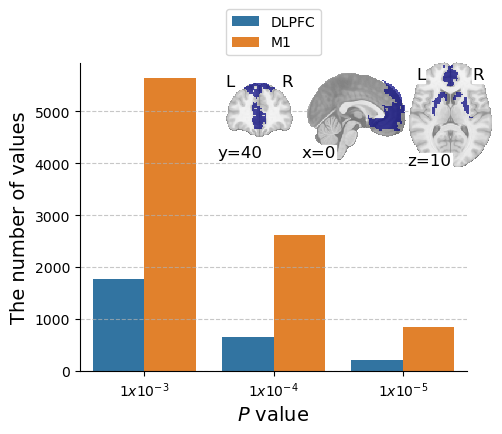

In [122]:
fig, ax = plt.subplots(figsize=(5,4))

g = sns.barplot(
    data=df, x='pval', y='nvoxels', hue='region'
#     , order=('M1_cTBS', 'dlPFC_cTBS')
    , ax=ax
)
g.set_xlabel(r'$P$ value', fontsize=14)
g.set_xticklabels([r'$1x10^{-3}$', r'$1x10^{-4}$', r'$1x10^{-5}$'])
g.set_ylabel(r'The number of values', fontsize=14)
g.grid(axis='y', linestyle='--', alpha=0.7)
g.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncol=1)

## Bounding box
bbox = g.get_position()
rect = (0.4, 0.6, 0.55, 0.3) # (x0, y0, w, h)
ax_insert = fig.add_axes(rect)
nilearn.plotting.plot_roi(
    join(dir_mask, 'mask.NN=1.clust0001.p=1.e-3.nii')
    , display_mode='ortho', draw_cross=False
    , cut_coords=[0, 40, 10]
    , axes=ax_insert
)

sns.despine()

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/barplot.%s.nvoxels.png'%glm
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)